In [1]:
import os
os.chdir('../')

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances
from src.XAI.torch_probing import train_probes

In [3]:
env_steps = Concept.load_concept_data()
# Model doesn't matter, but train_probes creates data for each layer.
# The first layer doesn't use model activations though.
# So currently the easiest way to train input probes
model_path = QNetwork.find_newest_model()
model = QNetwork(frame_stacks=4, model_path=model_path)

In [4]:
lr = (0.1, 0.01, 0.001, 0.0001)
batch_size = (64, 256, 1024)

# Permute all hyperparameters
hyperparams = []
for lr_ in lr:
    for batch_size_ in batch_size:
        hyperparams.append({
            'lr': lr_,
            'lambda_l1': 0.0,
            'patience': 5,
            'epochs': 100,
            'batch_size': batch_size_,
        })
        
print(f'Number of hyperparameters: {len(hyperparams)}')

Number of hyperparameters: 12


Best hyperparameter: {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 5, 'epochs': 100, 'batch_size': 256}
player x position | train data: 4000 | test data: 1000 score: 0.72 | time elapsed: 60.71s


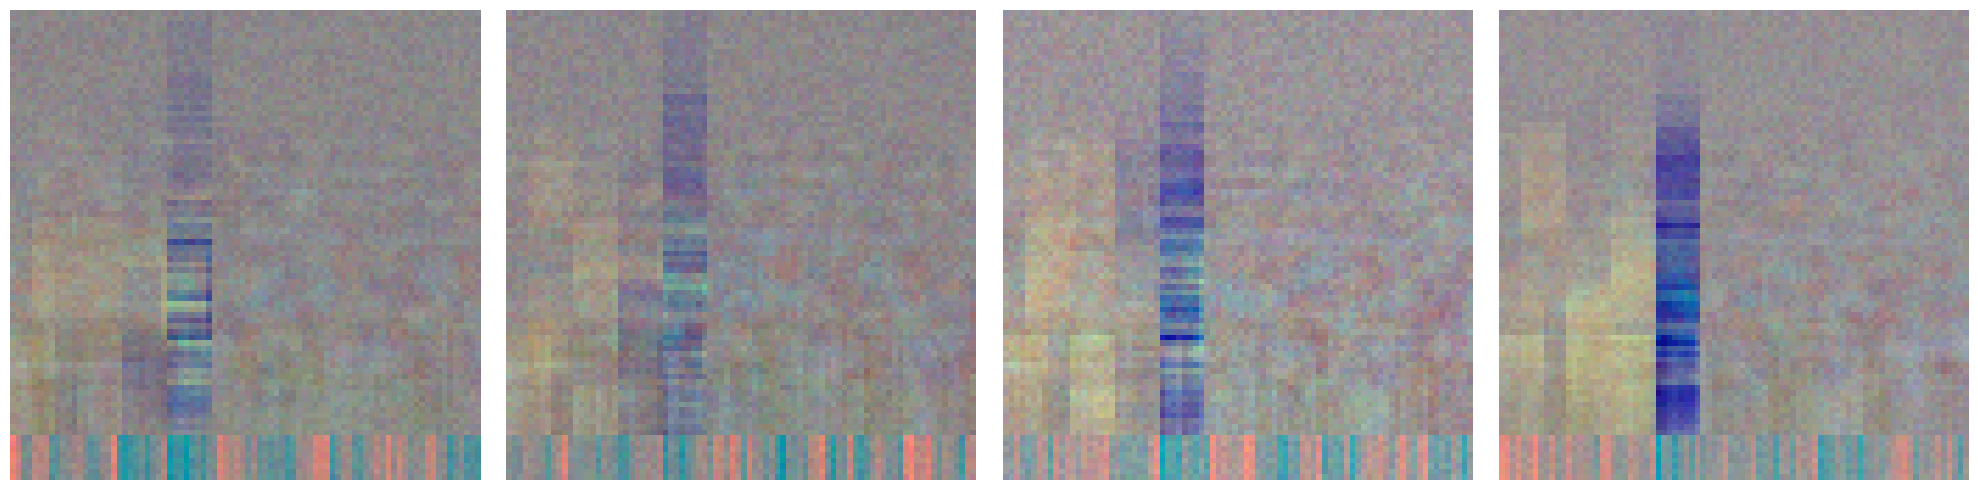

Best hyperparameter: {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 5, 'epochs': 100, 'batch_size': 64}
player y position | train data: 4000 | test data: 1000 score: 0.94 | time elapsed: 69.83s


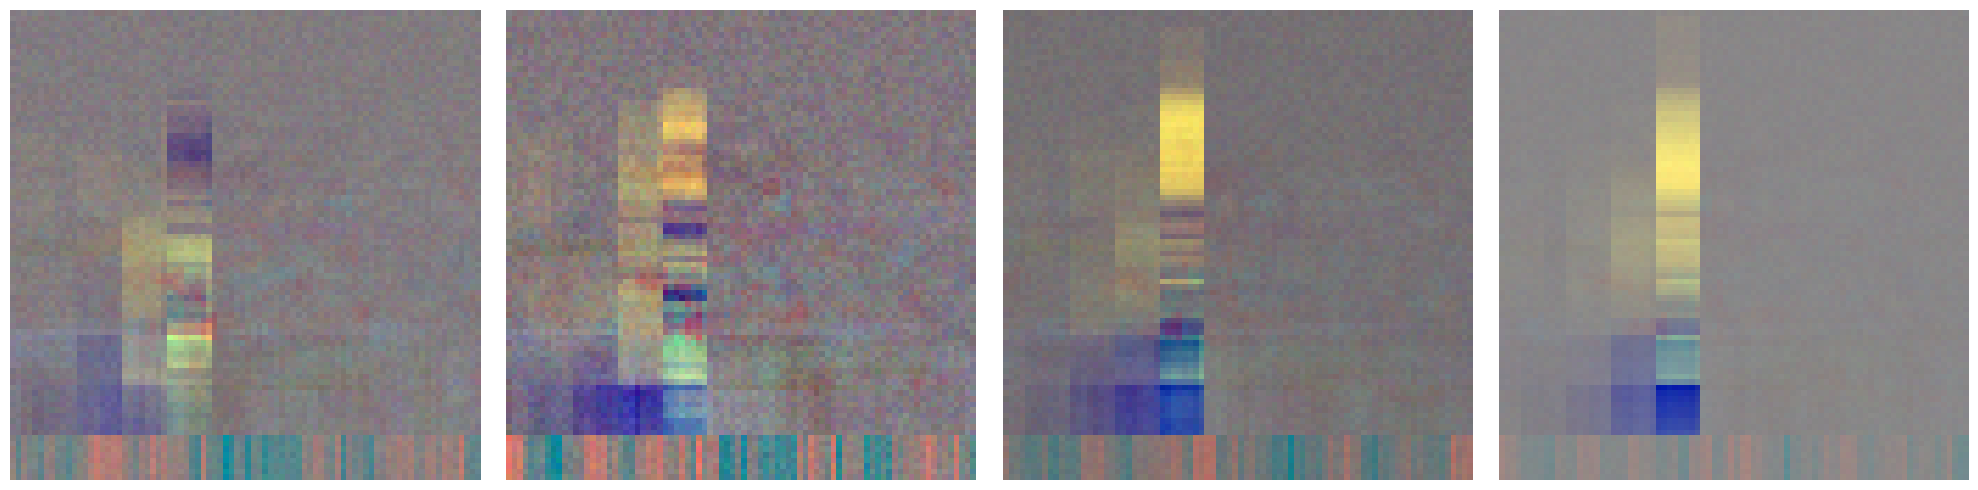

Best hyperparameter: {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 5, 'epochs': 100, 'batch_size': 256}
camera x position | train data: 4000 | test data: 1000 score: 1.00 | time elapsed: 104.89s


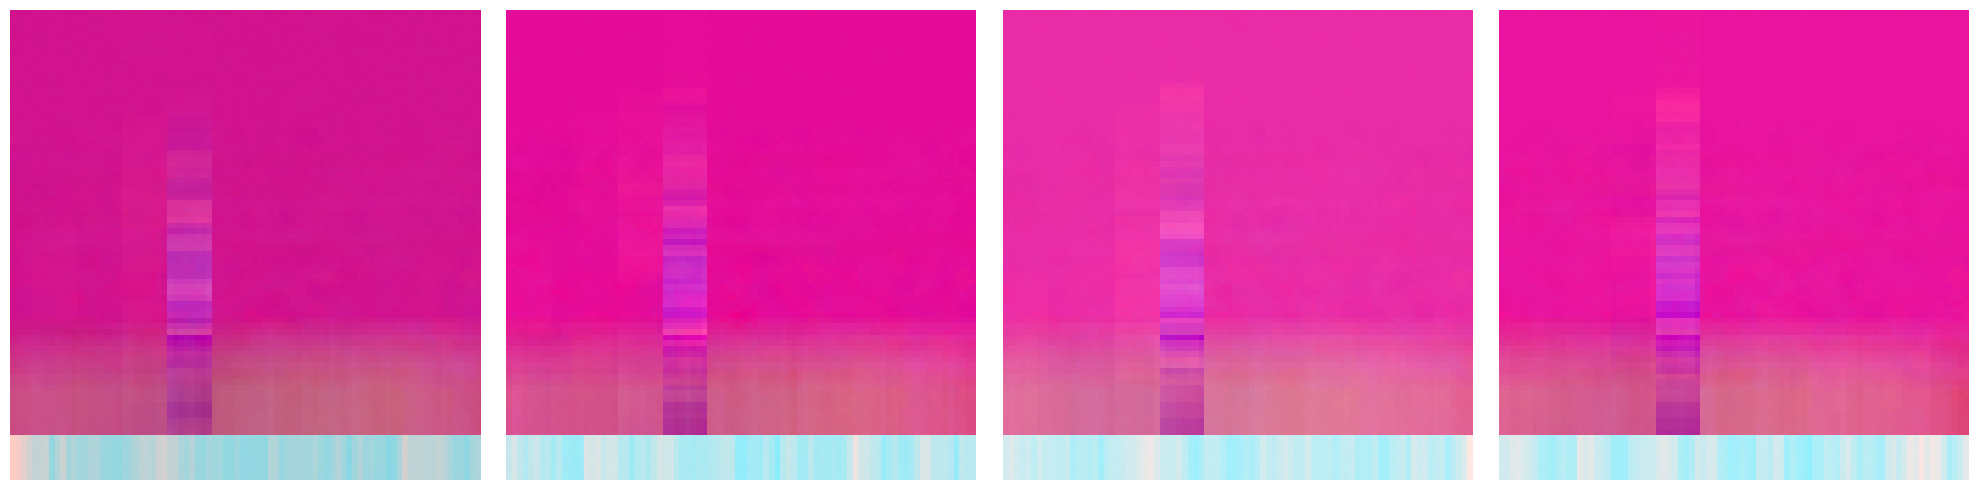

Best hyperparameter: {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 5, 'epochs': 100, 'batch_size': 64}
player in air | train data: 4000 | test data: 1000 score: 0.02 | time elapsed: 13.74s


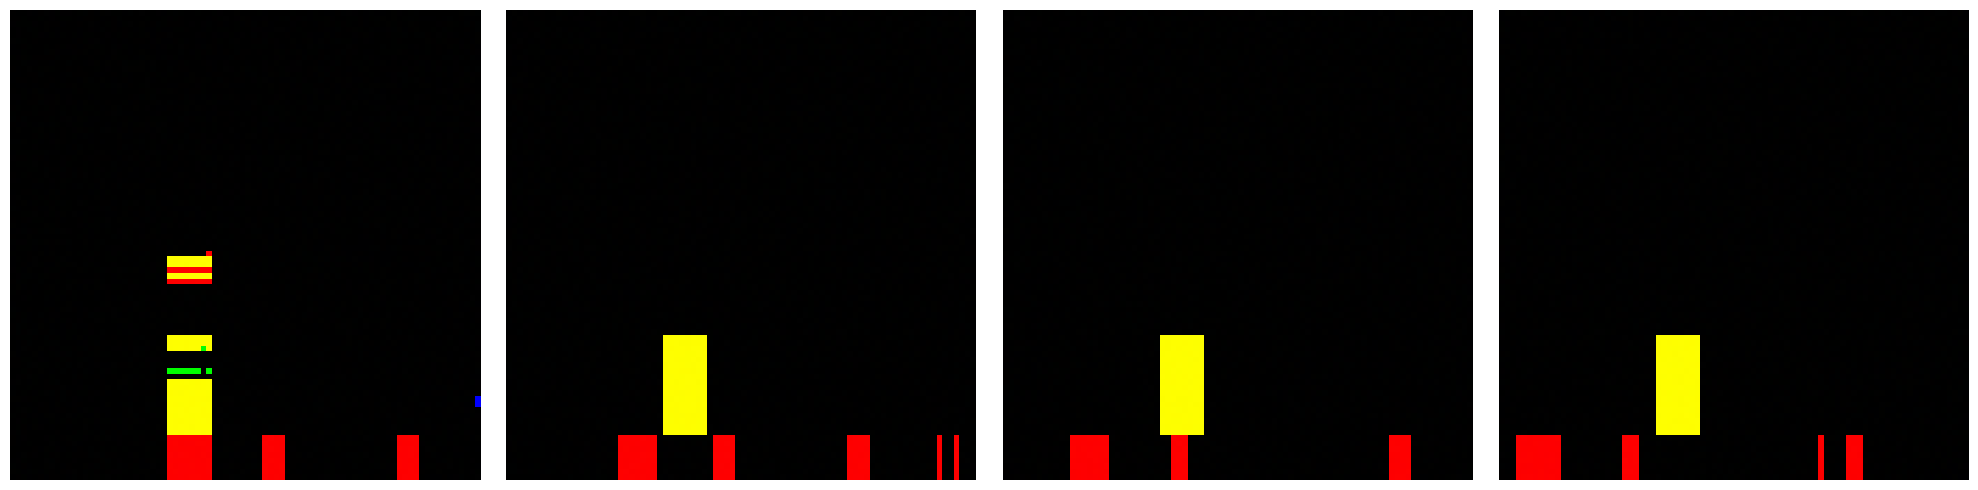

Best hyperparameter: {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 5, 'epochs': 100, 'batch_size': 256}
player dodging in air | train data: 1060 | test data: 266 score: 0.48 | time elapsed: 4.04s


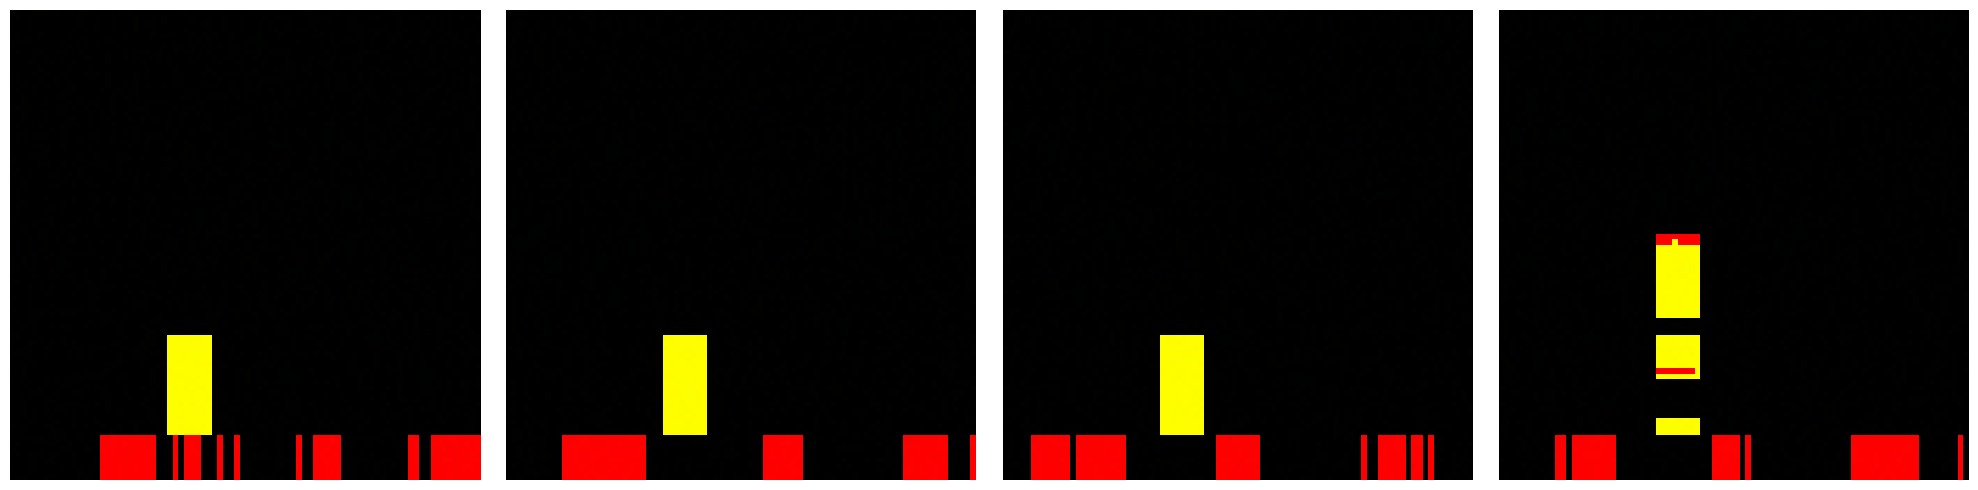

Best hyperparameter: {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 5, 'epochs': 100, 'batch_size': 256}
player fall velocity | train data: 4000 | test data: 1000 score: 0.71 | time elapsed: 54.16s


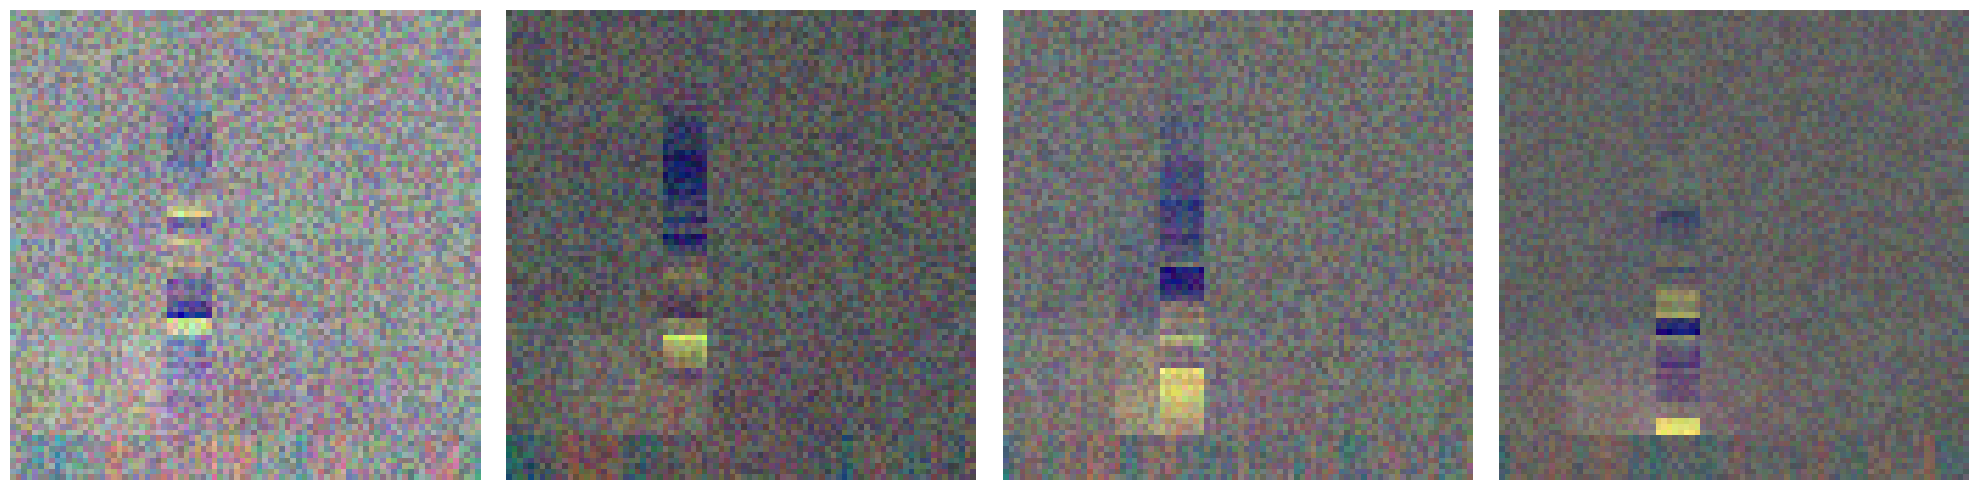

Best hyperparameter: {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 5, 'epochs': 100, 'batch_size': 64}
player standing on wall | train data: 4000 | test data: 1000 score: 0.02 | time elapsed: 11.95s


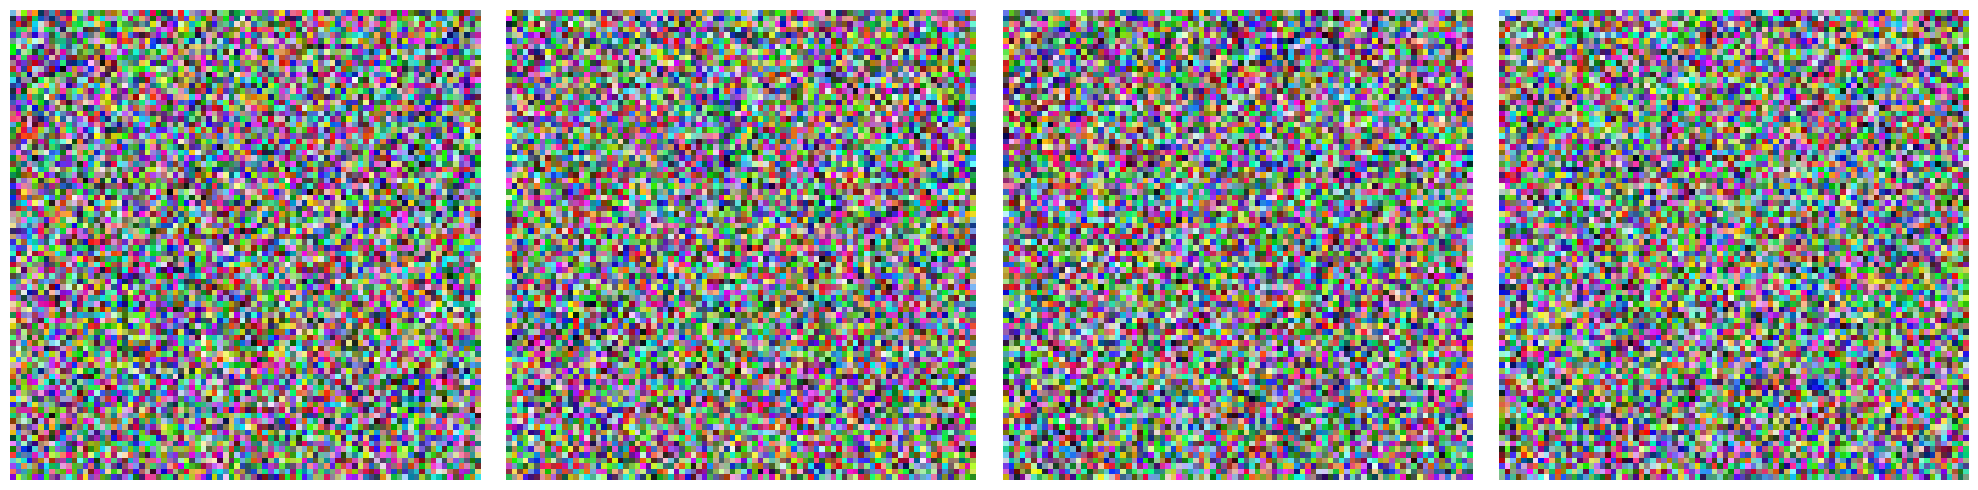

Best hyperparameter: {'lr': 0.0001, 'lambda_l1': 0.0, 'patience': 5, 'epochs': 100, 'batch_size': 64}
player dodging on wall | train data: 560 | test data: 140 score: 0.57 | time elapsed: 1.98s


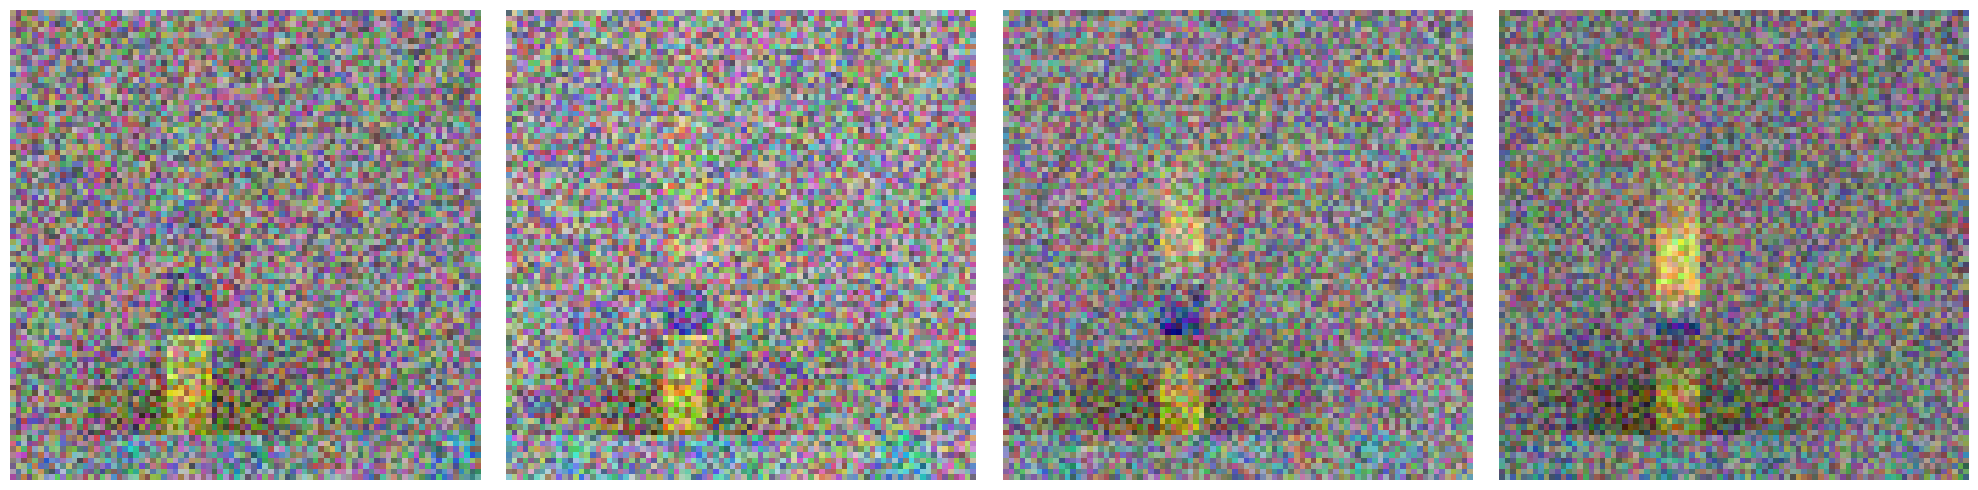

Best hyperparameter: {'lr': 0.0001, 'lambda_l1': 0.0, 'patience': 5, 'epochs': 100, 'batch_size': 1024}
visible events | train data: 4000 | test data: 1000 score: 0.52 | time elapsed: 40.09s


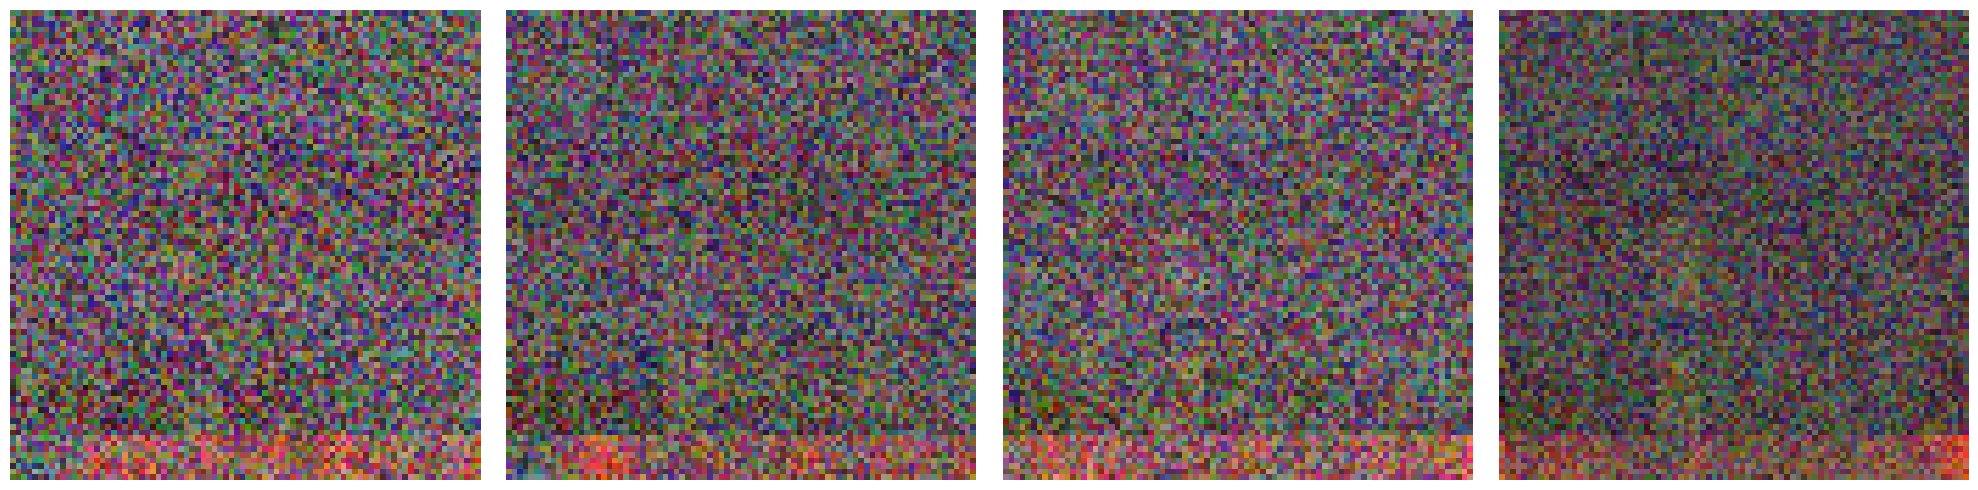

Best hyperparameter: {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 5, 'epochs': 100, 'batch_size': 64}
visible wall | train data: 4000 | test data: 1000 score: 0.02 | time elapsed: 11.50s


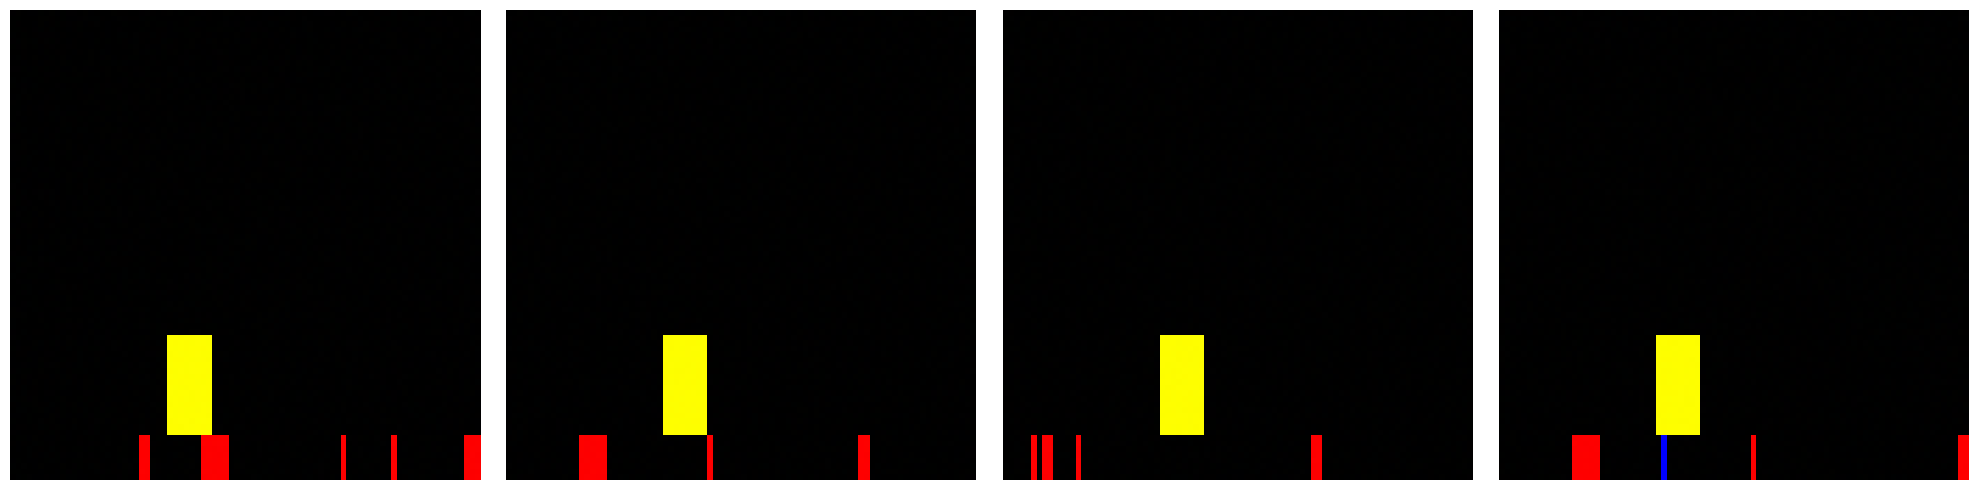

Best hyperparameter: {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 5, 'epochs': 100, 'batch_size': 64}
visible bullet | train data: 4000 | test data: 1000 score: 0.02 | time elapsed: 12.33s


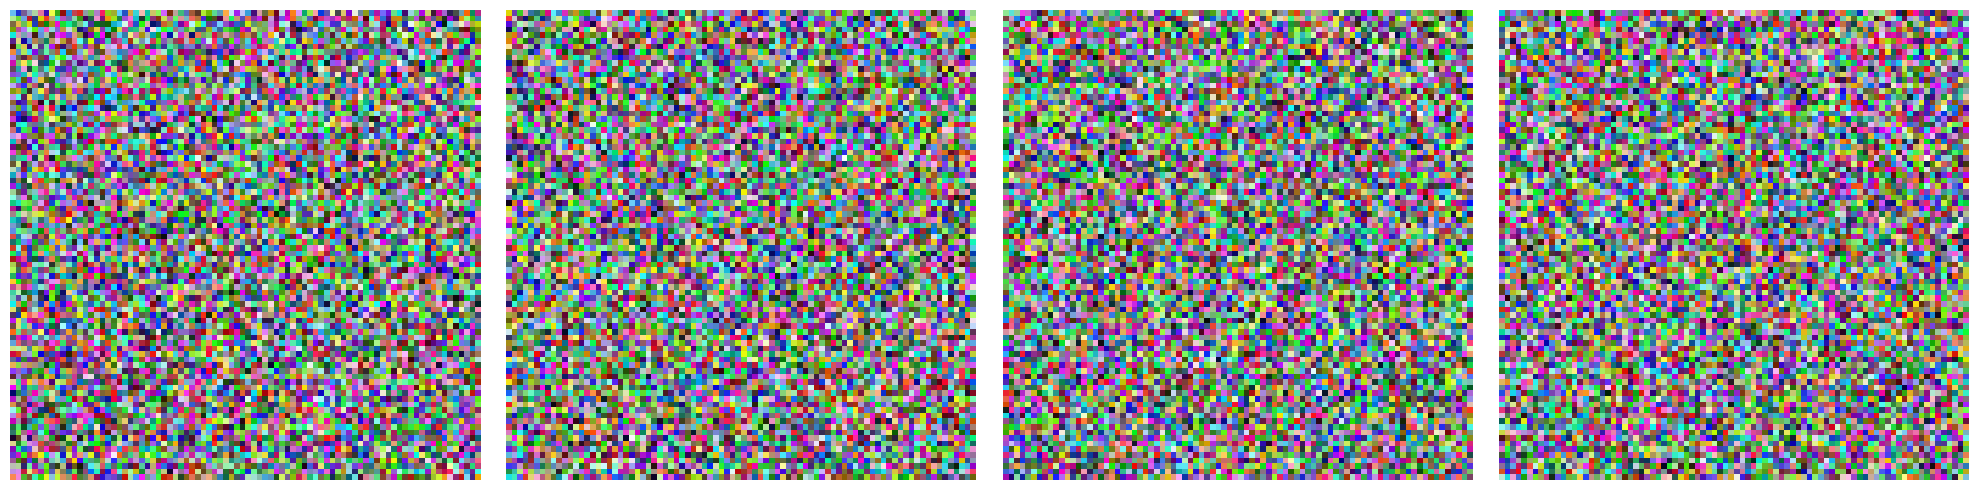

Best hyperparameter: {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 5, 'epochs': 100, 'batch_size': 256}
number visible lava | train data: 4000 | test data: 1000 score: 0.88 | time elapsed: 52.62s


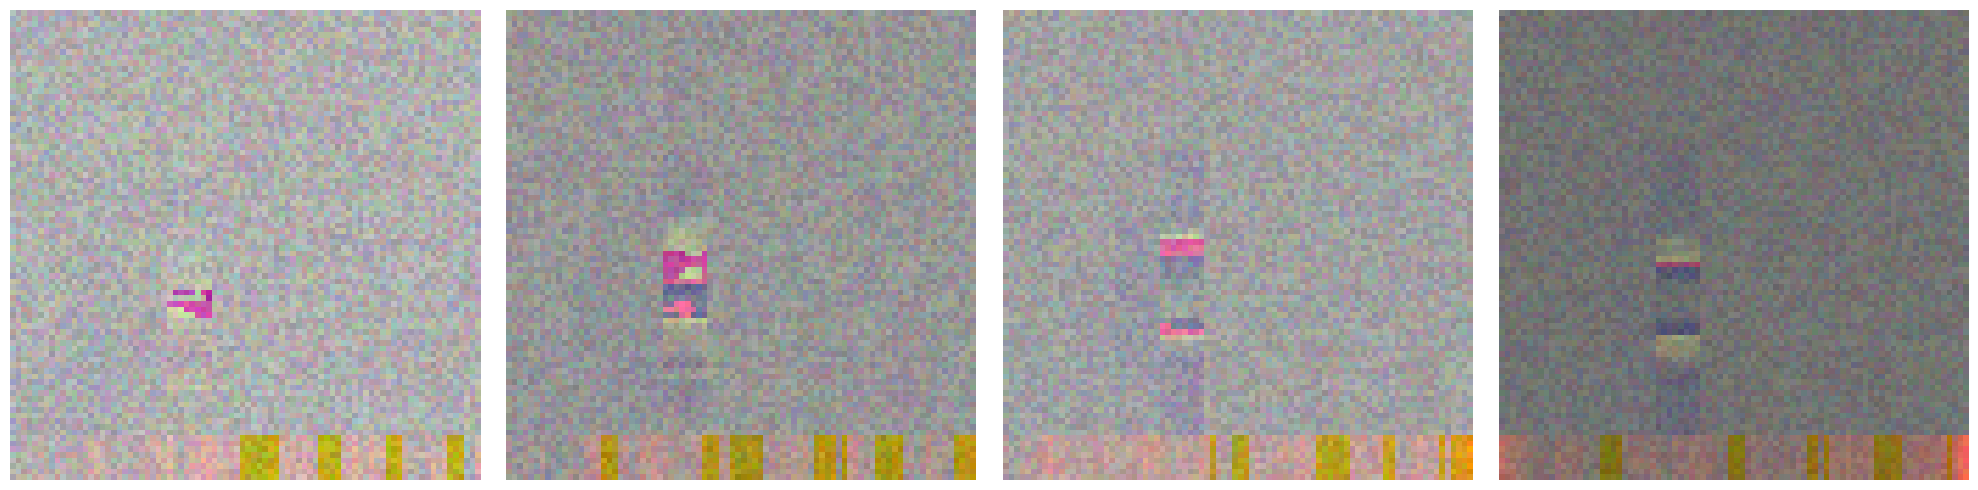

In [5]:
start = time.time()
layer = -1 # input layer, independent of model
for concept in concept_instances.values():
    concept.prepare_data(env_steps, max_size=5000)

    layer_probes, layer_info = train_probes(model, concept, hyperparams, [layer])
    score = layer_info[layer]['test_score'][-1]
    probe = layer_probes[layer]
    print(f'{concept.name} | train data: {len(concept.train_data)} | test data: {len(concept.test_data)} score: {score:.2f} | time elapsed: {time.time()-start:.2f}s')
    coeffs = probe[1].weight.data.cpu().numpy()
    coeffs = coeffs.reshape(84, 84, 12)
    coeffs -= coeffs.min()
    coeffs /= coeffs.max()
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Plot each frame stack
    for i in range(0, 12, 3):
        # Stack RGB channels
        img = np.stack([coeffs[:, :, i], coeffs[:, :, i+1], coeffs[:, :, i+2]], axis=2)
        img = (img - img.min()) / (img.max() - img.min())
        axs[i//3].imshow(img)
        axs[i//3].axis('off')

    plt.tight_layout()
    plt.savefig(f'figures/input availability/{concept.name}.png')
    plt.show()
   
    start = time.time()